# Binary Data Models
- categories: [Julia, Turing]

Coinflipping is a time honored example for probability exercises, and for good reason. It is readily interpretable while providing ample opportunity for more complex scenarios. Nevermind that "unfair" coins are essentially impossible to make... In any case, a few examples of coin flipping!

In [39]:
#collapse
using Turing
using Gadfly
using DataFrames, DataFramesMeta

## Scenario: Standard Fair(?) Coin Estimation
The simplest possible example: imagine we have a coin that might (or might not!) be fair. blah blah

In [55]:
@model function coinflip(y)
    # prior on p
    p ~ Beta(1, 1)
    
    # updates on p
    for i in 1:length(y)
        y[i] ~ Bernoulli(p)
    end
end;

In [41]:
data = [1,1,1,0,0,1,0,0,1,1,1,1,1,0,0,0,0,0,1,0,0,1,0,0]

# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 2000
ϵ = 0.05
τ = 10;

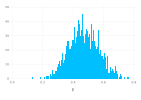

In [42]:
# Start sampling.
chain_bernoulli = sample(coinflip(data), HMC(ϵ, τ), iterations, progress=false);
plot(DataFrame(chain_bernoulli), x=:p, Geom.histogram)

Just to be clear, there are equivalent models that express the exact same underlying phenomena. Here's one example using `Binomial` in place of `Bernoulli`:

In [43]:
@model function coinflip_binomial(heads::Int64, flips::Int64)
    # prior on p
    p ~ Beta(2, 2)
    
    # update on p
    heads ~ Binomial(flips, p)
end;

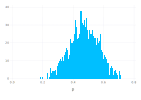

In [44]:
heads = sum(data)
flips = length(data)
chain_binomial = sample(coinflip_binomial(heads, flips), HMC(ϵ, τ), iterations, progress=false);
plot(DataFrame(chain_binomial), x=:p, Geom.histogram)

Note that the inference here should be faster than the Bernoulli case especially as the volume of data increases. The log-likelihood calculations in each sample loop are $O(1)$ versus $O(\mathrm{rows})$ in the Bernoulli variant. Let's take a look with a modestly larger dataset.

In [46]:
long_data = repeat(data, 100);
@time sample(coinflip(long_data), HMC(ϵ, τ), iterations, progress=false);

 80.996511 seconds (634.32 M allocations: 18.929 GiB, 7.05% gc time)


In [47]:
heads = sum(long_data)
flips = length(long_data)
@time sample(coinflip_binomial(heads, flips), HMC(ϵ, τ), iterations, progress=false);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.524443 seconds (1.26 M allocations: 74.442 MiB, 4.14% gc time)


Note that the following won't work, due to design choices in Turing:

In [48]:
@model function coinflip_BROKEN_THIS_WONT_WORK_AAAAAGH(y::Array{Int64})
    # prior on p
    p ~ Beta(1, 1)
    
    # updates on p
    heads = sum(y)                    # these lines are
    heads ~ Binomial(length(y), p)    # the problem
end;

The reason is that Turing assumes that all variables on the left hand side of `~` are either 
1. random variables (generated by Turing) or
2. declared as inputs to the function

By way of analogy to Stan, the `@model` block is only intended to represent the `parameter`, `tranformed parameter` and `model` blocks. As Turing is just Julia code, this is little inconvenience (just do the data transformations in Julia first!) but it can be a bit of a surprise and the error message is difficult to interpret.

## Scenario: Autocorrelation

Neato! So, the simplest case is pretty easy to work with. Unfortunately, it also has a bunch of assumptions built into it. The biggest such example is that coin flips are independent trials (or at least assumed to be...). 

Assume instead we're dealing with some arbitrary binary data (a bit stream). In that case, all sorts of surprising behavior is still on the table. For instance, we could have some data that has a *lot* of streaks (1, 1, 1, 1, 1, 1, ...)? If we retained our incorrect assumption of independence then our point estimate of `p` will not converge as quickly as expected, and our confidence intervals will be much too narrow. In other words, if we have positive autocorrelation (flipping a 1 is more likely if the preceeding flip was also a 1, and the reverse) then our estimates will just be wrong unless we account for it explicitly.

Let's generate some data in a way that very explicitly shows the connection to the previous datapoint:

In [49]:
data_autocor = [1]
p_1 = 0.85
p_2 = 0.15
for i in 2:1000
    if data_autocor[i-1] == 1
        p = p_1
    else
        p = p_2
    end
    data_autocor = cat(data_autocor, rand(Bernoulli(p)), dims=1)
end

And here's a model - it's not an accident that the model code looks so close to the data generating code!

In [50]:
@model function coinflip_autocor(y::Array{Int64})
    # prior on p
    p_1 ~ Beta(1, 1)
    p_2 ~ Beta(1, 1)
    
    y[1] ~ Bernoulli(p_1)
    for i in 2:length(y)
        if y[i-1] == 1
            p = p_1
        else
            p = p_2
        end
        y[i] ~ Bernoulli(p)
    end
end;

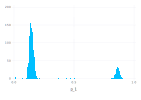

In [51]:
chain_autocor = sample(coinflip_autocor(data_autocor), HMC(ϵ, τ), iterations, progress=false);
plot(DataFrame(chain_autocor), layer(x=:p_1, Geom.histogram), layer(x=:p_2, Geom.histogram))

How to do this with an honest covariance matrix? ie over zip(y[:-1], y[2:])?
What about a "rich get richer" scenario? P(1) ~ b + length of streak of 1s
- would look good but how to diagnose issues?
    - distributions of streaks! a lot of extremely long streaks, a lot of short streaks... 

what about a "machine error" - double readings for both or one of 1s / 0s?

## Scenario: Rich get Richer
Look, we're long passed the physical analogy making sense for this data so just roll with it for now. The idea for this scenario is a minor extension of the former: every consecutive flip heads makes it more likely the next flip will also be heads, and the reverse for tails.

In [52]:
function streaks(arr)
    streaks = []
    val = arr[1]
    current_streak = 1
    for i in 2:length(arr)
        next_val = arr[i]
        if next_val == val
            current_streak = current_streak + 1
        else
            streaks = cat(streaks, current_streak, dims=1)
            val = next_val
            current_streak = 1
        end
    end
    streaks = cat(streaks, current_streak, dims=1)
    return streaks
end;

In [53]:
streaks([1,1,1,1,2,2,2,2,3,2,1,2,2,2,1])

7-element Array{Any,1}:
 4
 4
 1
 1
 1
 3
 1

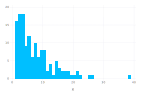

In [54]:
plot(DataFrame(x=streaks(data_autocor)), x=:x, Geom.histogram)

## Scenario: Many Coins of Discrete Biases

"data on several coins from specific mints. Coin of unknown origin with 10 flips, what is P(heads) on next flip?"

## Scenario: Many Coins with Continuous Biases

All coins come from one rather shitty mint. How shitty is that mint, and how shitty is this coin?

$$\mu_{mint} \sim \mathrm{Normal}(0,1)$$
$$\sigma_{mint} \sim \mathrm{Normal}(1, 2)$$

$$\mu_{coin} \sim \mathrm{Normal}(\mu_{mint}, \sigma_{mint})$$
$$ys \sim \mathrm{Bernoulli}(\mu_{coin})$$

Compare naive estimate and regularized estimate. Note: regularization lets us "share error" between

## "Seasonal" data
e.g. hourly aggregate from a motion sensor in a shop: "there was motion in the shop over the past hour"

## Extremely sparse data?